In [145]:
import os
import psycopg2
import datetime

import seaborn as sns
sns.set()
sns.set_style("darkgrid")
sns.set_palette("bright")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
import scipy

%matplotlib inline

km_in_a_mile = 1.60934

def readConfig(key):
    config = pd.read_csv(r'c:\users\lkave\documents\github\config.txt', header = None)
    config = [c.split('=') for c in config[0]]
    out = [c[1] for c in config if c[0] == key][0]
    return(out)

def dbGetQuery(q):
    pw = readConfig('pw')
    conn_string = "host='kavdb.c9lrodma91yx.us-west-2.rds.amazonaws.com' dbname='kavdb' user='lkavenagh' password='" + pw + "'"
    conn = psycopg2.connect(conn_string)
    conn.autocommit = True
    dat = pd.read_sql(q, conn)
    conn.close()
    return(dat)

In [183]:
ls = ['5Ks', 'half marathons']
dists = [3.11, 13.1]
for n,dist in enumerate(dists):
    dat = dbGetQuery("""SELECT start_date, distance_miles, average_pace, manual as treadmill, minutes_elapsed, rank() over (partition by manual order by minutes_elapsed) as rnk \
                        FROM runs.activities_summary \
                        WHERE distance_miles BETWEEN {} and {} \
                        ORDER BY start_date DESC""".format(dist*0.99, dist*1.01))
    dat['year'] = [c.year for c in dat.start_date]

    yearly_pr = dat.groupby(['year', 'treadmill'], as_index = False).min()[['year', 'treadmill', 'average_pace', 'minutes_elapsed', 'rnk']]

    yearly_pr['pace_mins'] = [int(np.floor(c)) for c in yearly_pr.average_pace]
    yearly_pr['pace_sec'] = [int((c - np.floor(c))*60) for c in yearly_pr.average_pace]
    #hours, rem = divmod(end-start, 3600)
    yearly_pr['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in yearly_pr.minutes_elapsed*60]
    print('*** Best {} by year ***\n'.format(ls[n]))
    print(yearly_pr.sort_values(['treadmill', 'rnk'], ascending = True)[['year', 'treadmill', 'pace_mins', 'pace_sec', 'time_mins']])
    print(' ')
    
dist = 13.1
dat = dbGetQuery("""SELECT CAST(EXTRACT(year from start_date) as int) as yr, distance_miles, average_pace, minutes_elapsed, rank() over (partition by manual order by minutes_elapsed) as rnk
                    FROM runs.activities_summary
                    WHERE distance_miles BETWEEN {} and {}
                    ORDER BY minutes_elapsed ASC
                    LIMIT 10""".format(dist*0.99, dist*1.01))

dat['pace_mins'] = [int(np.floor(c)) for c in dat.average_pace]
dat['pace_sec'] = [int((c - np.floor(c))*60) for c in dat.average_pace]
dat['time_mins'] = ['{:0>2}:{:0>2}:{:0>2}'.format(int(divmod(c, 3600)[0]), int(divmod(divmod(c, 3600)[1], 60)[0]), int(divmod(divmod(c, 3600)[1], 60)[1])) for c in dat.minutes_elapsed*60]
print('*** Best half marathons all time ***\n')
print(dat.sort_values(['rnk'], ascending = True)[['yr', 'pace_mins', 'pace_sec', 'time_mins']])
print(' ')

*** Best 5Ks by year ***

    year treadmill  pace_mins  pace_sec time_mins
7   2016         0          6        40  00:20:39
4   2014         0          6        45  00:21:13
0   2012         0          6        50  00:21:20
13  2019         0          6        55  00:21:38
6   2015         0          7         2  00:21:56
2   2013         0          7         6  00:22:04
15  2020         0          7        44  00:26:07
9   2017         0          7        24  00:26:13
11  2018         0          8        42  00:27:44
16  2021         0          8        55  00:32:59
8   2016         1          6        21  00:19:51
14  2019         1          6        35  00:20:35
3   2013         1          6        47  00:21:02
10  2017         1          6        57  00:21:38
1   2012         1          7        25  00:23:00
5   2014         1          7        54  00:24:30
12  2018         1          8        32  00:26:30
 
*** Best half marathons by year ***

   year treadmill  pace_mins  pace_

# YTD activities

In [184]:
dat = dbGetQuery('SELECT * FROM runs.activities_summary ORDER BY start_date')
print(dat[['name', 'start_date', 'distance_miles', 'average_pace', 'manual']].tail(10))

dat = dat.append(dat.tail(1)).reset_index(drop = True)
dat.loc[len(dat)-1, 'start_date'] = datetime.datetime.now()
dat.loc[len(dat)-1, 'distance'] = 0

dat['year'] = [c.year for c in dat.start_date]
dat['doy'] = [c.timetuple().tm_yday for c in dat.start_date]

dat['distance_miles'] = [c for c in dat.distance_miles]
dat['ytd_distance'] = dat.groupby('year', as_index = False).cumsum()['distance_miles']
dat['generic_date'] = [datetime.date(1904,c.month,c.day) for c in dat.start_date]


                                                name          start_date  \
1343                                   Afternoon Run 2020-11-22 14:06:25   
1344  Sacramento Virtual Run To Feed The Hungry 2020 2020-11-26 12:07:08   
1345                                   Afternoon Run 2020-12-05 13:42:42   
1346                                     Morning Run 2020-12-12 10:56:30   
1347                                       Lunch Run 2020-12-26 12:22:24   
1348                                      Coffee run 2020-12-27 13:07:05   
1349                       Architecture running tour 2020-12-27 14:43:21   
1350                                     Morning Run 2021-01-18 10:50:04   
1351                                     Morning Run 2021-01-26 07:19:55   
1352                                   Afternoon Run 2021-01-28 17:58:17   

      distance_miles  average_pace manual  
1343        1.348690     10.850415      0  
1344        3.109473      9.461107      0  
1345        3.004026      9.166

In [169]:
target = 200

dat = dat[['start_date', 'generic_date', 'year', 'ytd_distance', 'distance_miles', 'doy']]

actual = dat.loc[dat.start_date == max(dat.start_date), 'ytd_distance'].item()

plot_dat = dat[['generic_date', 'year', 'ytd_distance']]
plot_dat = plot_dat.groupby(['generic_date', 'year'], as_index = False).max()
plot_dat = plot_dat.pivot_table(index = 'generic_date', columns = 'year')
plot_dat.columns = plot_dat.columns.droplevel().rename(None)
plot_dat = plot_dat.reset_index()
plot_dat = plot_dat.apply(lambda series: series.loc[:series.last_valid_index()].ffill())

x = range(len(plot_dat))
y = [(target / len(plot_dat)) * x for x in x]
plot_dat['target'] = y
t = datetime.datetime.today().date()
today_target = plot_dat.loc[plot_dat.generic_date == datetime.date(1904, t.month, t.day), 'target'].item()

In [170]:
lin = plot_dat[['generic_date', 2021]]
lin = lin.where(lin.ffill().notna(), 0)
y = list(lin.loc[~pd.isnull(lin[2021]), 2021])
x = list(range(len(y)))
m = scipy.stats.linregress(x, y)
lin['pred'] = [c*m.slope + m.intercept for c in list(lin.index)]

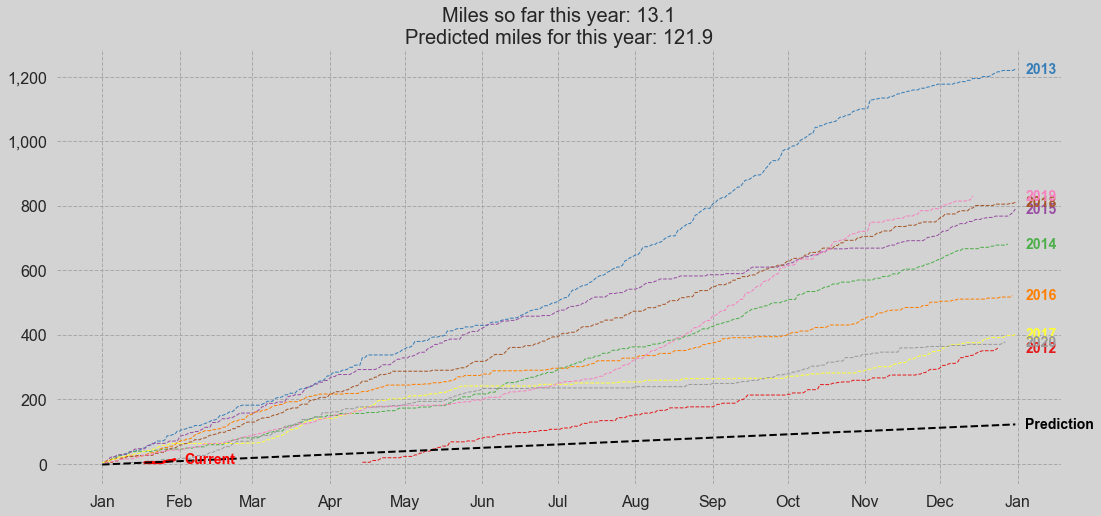

In [182]:
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)

colors = cm.Set1
for n,y in enumerate(plot_dat.columns[1:]):
    if y == 'target':
        continue
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k', linewidth = 2)
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Target', ha = 'left', va = 'center', fontweight = 'bold', color = 'k', fontsize = 14)
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
        ax.text(max(plot_dat.loc[~pd.isnull(plot_dat[y]), 'generic_date'])+datetime.timedelta(4), np.nanmax(plot_dat[y]), 'Current', ha = 'left', va = 'center', fontweight = 'bold', color = 'red', fontsize = 14)
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', linewidth = 1, color = colors(n))
        ax.text(plot_dat.generic_date[-1:]+datetime.timedelta(4), np.nanmax(plot_dat[y]), y, ha = 'left', va = 'center', fontweight = 'bold', color = colors(n), fontsize = 14)

ax.plot(lin.generic_date, lin['pred'], linestyle = '--', linewidth = 2, color = 'black')
ax.text(lin.generic_date[-1:]+datetime.timedelta(4), np.nanmax(lin['pred']), 'Prediction', ha = 'left', va = 'center', fontweight = 'bold', color = 'black', fontsize = 14)

for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

# ax.set_title('Target: {:,.1f} miles | Actual: {:,.1f} miles | Surplus: {:,.1f} miles\nPrediction: {:,.1f} miles'.format(today_target, actual, actual - today_target, lin.tail(1).pred.item()), fontsize = 20)
ax.set_title('Miles so far this year: {:,.1f}\nPredicted miles for this year: {:,.1f}'.format(actual, lin.tail(1).pred.item()), fontsize = 20)
# ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
#             ' Actual: ' + str(round(actual,1)) + ' miles |' + \
#             ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])
xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(float(y))))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)

No handles with labels found to put in legend.


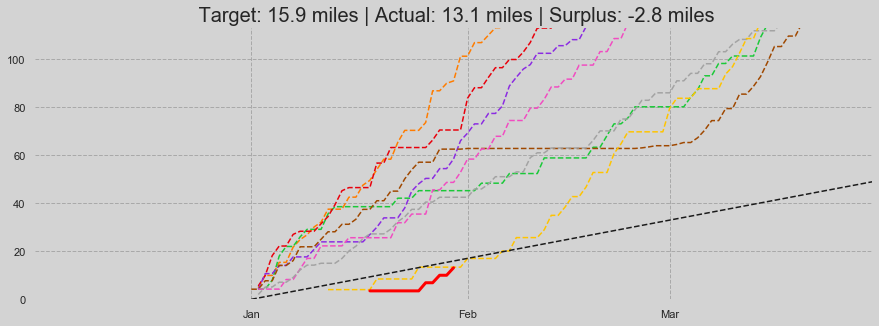

In [151]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in plot_dat.columns[1:]:
    if y == 'target':
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--', color = 'k')
    elif y == max([int(c) for c in plot_dat.columns[1:-1]]):
        ax.plot(plot_dat.generic_date, plot_dat[y], linewidth = 3, color = 'red')
    else:
        ax.plot(plot_dat.generic_date, plot_dat[y], linestyle = '--')

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'darkgrey')

ax.set_xticks([datetime.date(1904,c,1) for c in range(1,13)] + [datetime.date(1905,1,1)])

maxdate = plot_dat.loc[plot_dat[plot_dat.columns[-2]] == np.nanmax(plot_dat[plot_dat.columns[-2]]), 'generic_date'].head(1).item()
ax.set_xlim(maxdate - datetime.timedelta(60), maxdate + datetime.timedelta(60))

maxdistance = np.nanmax(plot_dat[plot_dat.columns[-2]])
ax.set_ylim(max(maxdistance - 100,0), maxdistance + 100)

ax.set_title(' Target: ' + str(round(today_target,1)) + ' miles |' + \
            ' Actual: ' + str(round(actual,1)) + ' miles |' + \
            ' Surplus: ' + str(round(actual - today_target,1)) + ' miles', fontsize = 20)

xfmt = mdates.DateFormatter('%b')
ax.get_figure().set_facecolor('lightgrey')
ax.set_facecolor('lightgrey')
ax.xaxis.set_major_formatter(xfmt)

# Miles by weekday

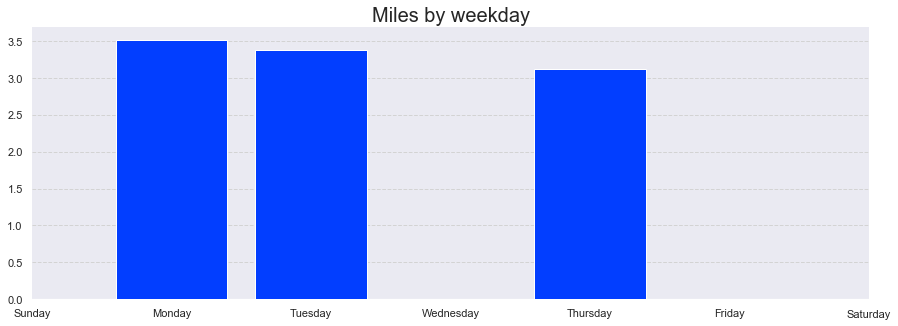

In [152]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, sum(distance_miles) as total_miles \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.total_miles, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Miles by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

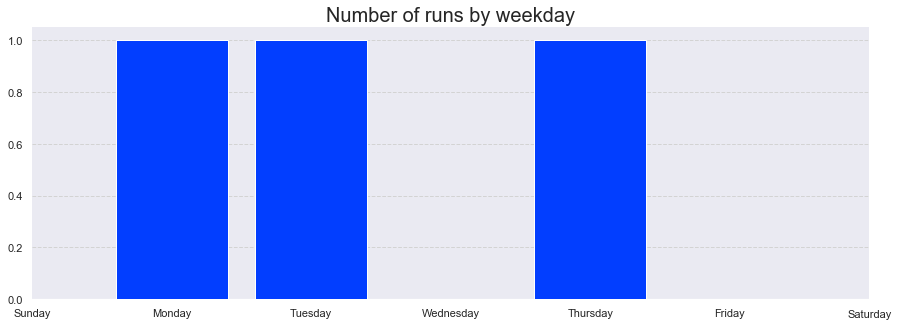

In [153]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, count(distance_miles) as num_activities \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.bar(dat.dow, dat.num_activities, zorder = 3)
ax.set_xticks([0,1,2,3,4,5,6])

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_title('Number of runs by weekday', fontsize = 20)
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

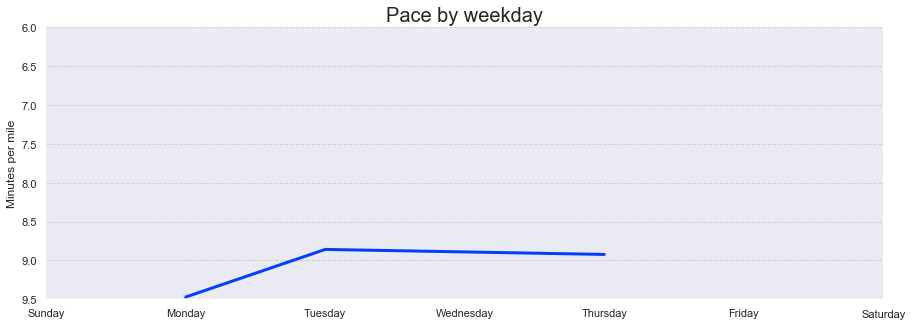

In [154]:
dat = dbGetQuery('SELECT EXTRACT(dow from start_date) as dow, sum(average_pace * distance_miles) / sum(distance_miles) as avg_pace \
                FROM runs.activities_summary \
                WHERE EXTRACT(year from start_date) = (SELECT max(EXTRACT(year from start_date)) FROM runs.activities) \
                GROUP BY 1 \
                ORDER BY 1')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

ax.plot(dat.dow, dat.avg_pace, linewidth = 3)

for var in ['top', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)
ax.set_ylim([6,9.5])
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')
ax.set_title('Pace by weekday', fontsize = 20)
ax.set_xticks([0,1,2,3,4,5,6])
x = ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

# Average pace

In [155]:
dat = dbGetQuery('SELECT start_date, average_speed, distance FROM runs.activities \
                    WHERE type = \'Run\' \
                    and average_speed > 3')
dat = dat.sort_values('start_date').reset_index(drop = True)
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat['average_pace'] = [(km_in_a_mile/60)/((0.00001+c) / 1000) for c in dat.average_speed]
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]

In [156]:
out = pd.DataFrame(columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD'])

for i in range(len(dat)):
    dat_7 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(7)))]
    dat_30 = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= (dat.start_date[i] - datetime.timedelta(30)))]
    dat_YTD = dat.loc[(dat.start_date <= dat.start_date[i]) & (dat.start_date >= pd.Timestamp(datetime.date(dat.start_date[i].year,1,1)))]

    pace_y = pace_30 = pace_YTD = None
    if len(dat_7) > 0:
        pace_7 = np.nansum(dat_7.distance * dat_7.average_pace) / np.nansum(dat_7.distance)
    if len(dat_30) > 0:
        pace_30 = np.nansum(dat_30.distance * dat_30.average_pace) / np.nansum(dat_30.distance)
    if len(dat_YTD) > 0:
        pace_YTD = np.nansum(dat_YTD.distance * dat_YTD.average_pace) / np.nansum(dat_YTD.distance)

    out = out.append(pd.DataFrame([[dat.start_date[i].date(),
                            pace_7,
                            pace_30,
                            pace_YTD]], columns = ['date', 'average_pace_7', 'average_pace_30', 'average_pace_YTD']
                         ))
out = out.sort_values('date')

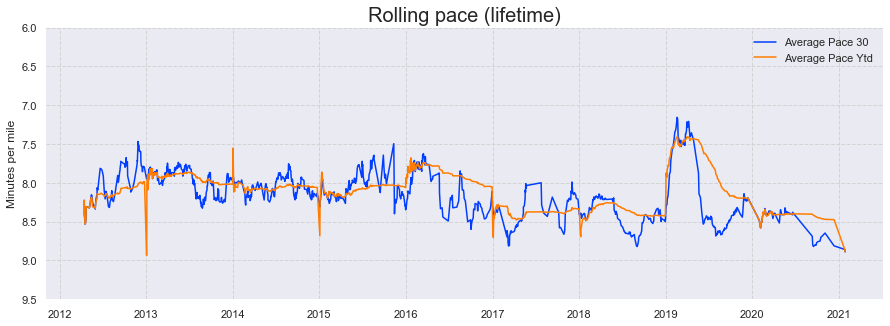

In [157]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[2:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')
ax.set_title('Rolling pace (lifetime)', fontsize = 20)
ax.set_ylim(6, 9.5)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

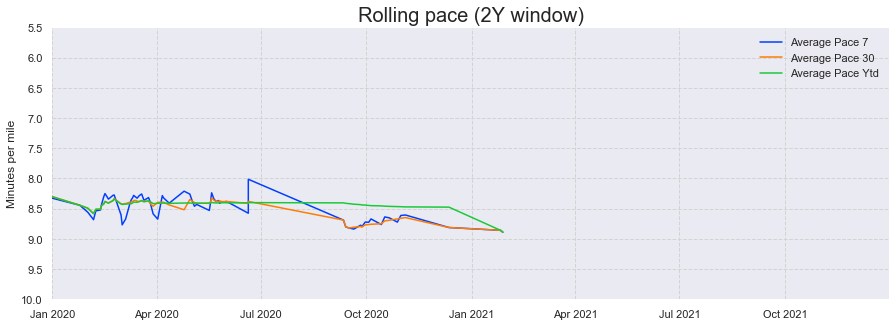

In [158]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

for y in out.columns[1:]:
    ax.plot(out.date, out[y], label = y.replace('_', ' ').title())

ax.legend(frameon = False)
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)
    
ax.grid(linestyle = '--', color = 'lightgrey')

ax.set_title('Rolling pace (2Y window)', fontsize = 20)
ax.set_xlim(datetime.date(max(out.date).year-1, 1, 1), datetime.date(max(out.date).year, 12, 31))
ax.set_ylim(5.5,10)
ax.invert_yaxis()
ax.set_ylabel('Minutes per mile')

# ax.plot([datetime.date(2019,1,1), datetime.date(2019,12,31)], [6.4, 6.4], color = 'red', linestyle = '--')
# ax.text(x = datetime.date(2019,1,1), y = 6.3, s = 'Race pace goal', color = 'red')

xfmt = mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(xfmt)

## High mileage weeks

In [159]:
lim = 30

dat = dbGetQuery('SELECT start_date, distance_miles FROM runs.activities_summary')
dat = dat.sort_values('start_date')
dat['weeknum'] = [(c - datetime.timedelta(c.weekday())).date() for c in dat.start_date]
dat = dat.groupby('weeknum', as_index = False).sum()
dat = dat.sort_values('weeknum')
dat = dat.loc[dat.distance_miles >= lim]
dat.weeknum = [c.strftime("%d %b, '%y") for c in dat.weeknum]
dat = dat.reset_index(drop = True)

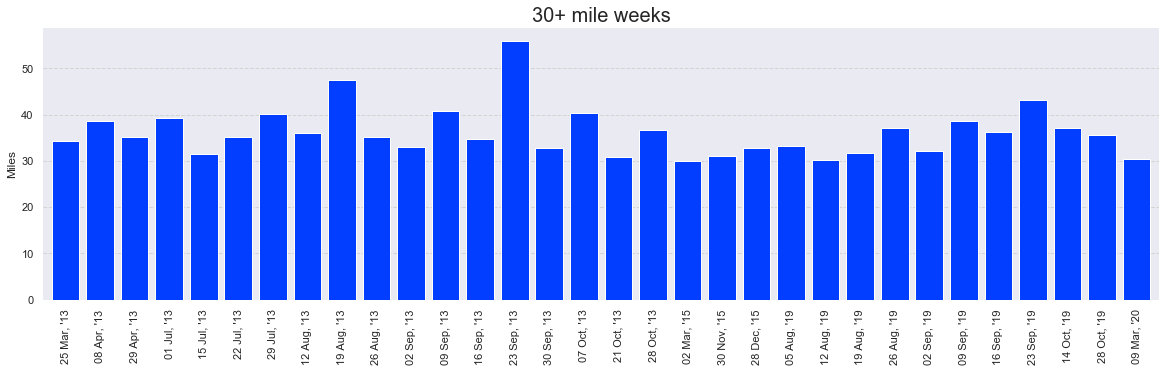

In [160]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)

dat = dat.set_index('weeknum')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('{}+ mile weeks'.format(lim), fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly elevation gain

In [161]:
dat = dbGetQuery('SELECT start_date, total_elevation_gain FROM runs.activities WHERE type = \'Run\'')

In [162]:
dat = dbGetQuery('SELECT start_date, total_elevation_gain * 3.28084 as total_elevation_gain FROM runs.activities WHERE type = \'Run\'')
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')

dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)

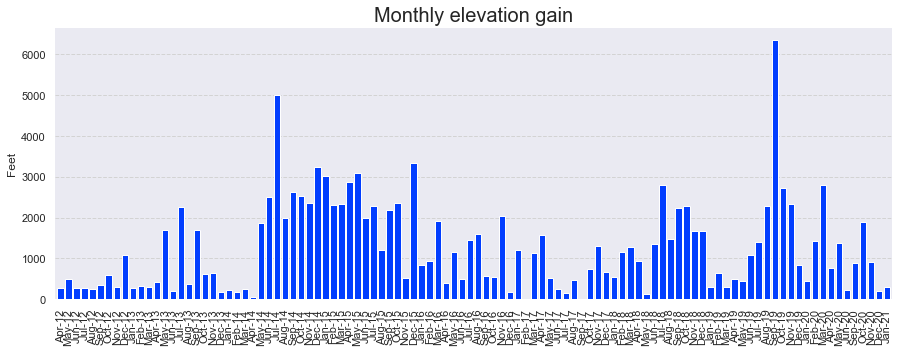

In [163]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat = dat.set_index('month')
dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend_.remove()
for var in ['top', 'bottom', 'left', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Feet')
ax.set_title('Monthly elevation gain', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)

# Monthly mileage

In [164]:
dat = dbGetQuery('SELECT start_date, distance FROM runs.activities WHERE type = \'Run\'')
dat.distance = [(c/1000)/km_in_a_mile for c in dat.distance]
dat = dat.sort_values('start_date')
dat['month'] = [datetime.date(c.year, c.month, 1) for c in dat.start_date]
dat = dat.groupby('month', as_index = False).sum()
dat = dat.sort_values('month')
dat.month = [c.strftime('%b-%y') for c in dat.month]
dat = dat.reset_index(drop = True)
dat = dat.set_index('month')

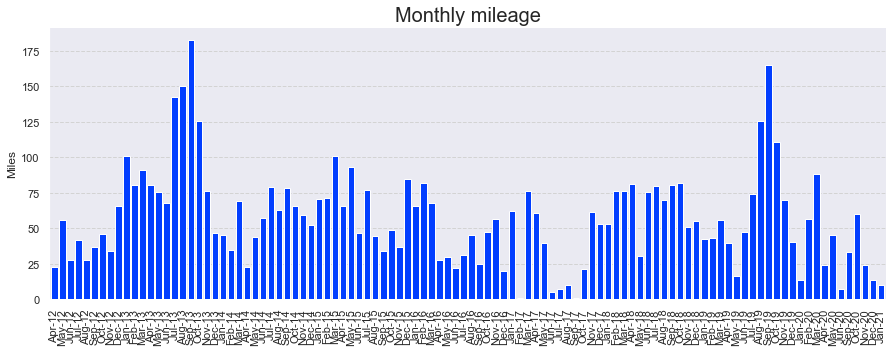

In [165]:
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

dat.plot(kind = 'bar', ax = ax, width = 0.8)

ax.legend().remove()
for var in ['top', 'bottom', 'right']:
    ax.spines[var].set_visible(False)

ax.set_xlabel('')
ax.set_ylabel('Miles')
ax.set_title('Monthly mileage', fontsize = 20)
ax.grid(linestyle = '--', color = 'lightgrey')
ax.xaxis.grid(False)